# Anomoly Detection


In [115]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import pandas as pd

In [116]:
#!pip install tensorflow-gpu

In [117]:
BATCH_SIZE = 32
IMAGE_SIZE = 128
CHANNELS = 3
EPOCHS = 20

### Import data into tensorflow dataset object

In [118]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "datasett",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 1915 files belonging to 2 classes.


In [119]:
#This will show the classes names that exists
class_names = dataset.class_names
class_names

['FIRE', 'GUN']

In [120]:
dataset.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

(32, 128, 128, 3)
[0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0]


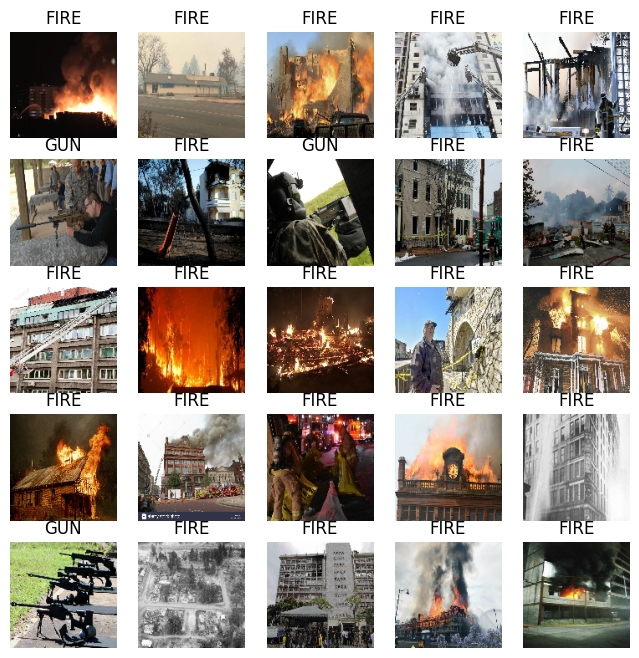

In [121]:
plt.figure(figsize=(8,8))
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())
    
    #ploting images
    for i in range(25):
        ax = plt.subplot(5,5,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        #plt.scatter(image_batch[i], class_names[labels_batch[i]], c='blue')
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [122]:
names = []
s = []
for image_batch, labels_batch in dataset.take(1):
    #print(image_batch.shape)
    print(labels_batch.numpy())
 
    for i in range(32):
        data = pd.DataFrame(labels_batch)
        names = class_names[labels_batch[i]]
        s.append(names)
        print(s[i])
 

       

[0 0 0 0 1 0 1 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 1 1 0 0 0]
FIRE
FIRE
FIRE
FIRE
GUN
FIRE
GUN
FIRE
FIRE
FIRE
FIRE
GUN
FIRE
FIRE
GUN
FIRE
FIRE
FIRE
FIRE
GUN
FIRE
FIRE
GUN
FIRE
FIRE
FIRE
FIRE
GUN
GUN
FIRE
FIRE
FIRE


In [123]:
len(s)

32

In [124]:
len(data)

32

In [125]:
data['names'] = s

In [126]:
data

,0,names
0,0,FIRE
1,0,FIRE
2,0,FIRE
3,0,FIRE
4,1,GUN
5,0,FIRE
6,1,GUN
7,0,FIRE
8,0,FIRE
9,0,FIRE


In [127]:
data.rename(columns={0:'id'}, inplace = True)

In [128]:
data.head()


,id,names
0,0,FIRE
1,0,FIRE
2,0,FIRE
3,0,FIRE
4,1,GUN


In [129]:
import numpy as np
np.unique(data['id'])

array([0, 1])

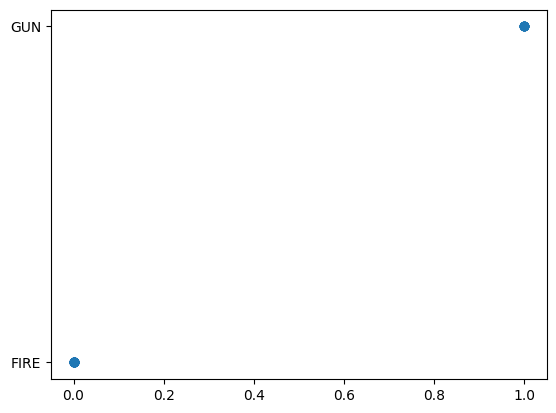

In [130]:
plt.scatter(data.id, data.names)

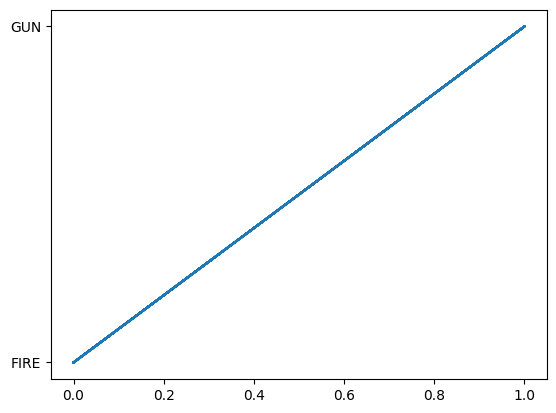

In [131]:
plt.plot(data.id, data.names)

In [132]:
len(dataset)

60

In [133]:
train_size = 0.8
len(dataset)*train_size

48.0

In [134]:
train_ds = dataset.take(20)
len(train_ds)

20

In [135]:
test_ds = dataset.skip(20)
len(test_ds)

40

In [136]:
val_size=0.1
len(dataset)*val_size

6.0

In [137]:
val_ds = test_ds.take(2)
len(val_ds)

2

In [138]:
test_ds = test_ds.skip(2)
len(test_ds)

38

## Partitioning Data 

In [139]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [140]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [141]:
len(train_ds)

48

In [142]:
len(val_ds)

6

In [143]:
len(test_ds)

6

In [144]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [145]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [146]:
'''data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])'''

'data_augmentation = tf.keras.Sequential([\n  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),\n  layers.experimental.preprocessing.RandomRotation(0.2),\n])'

In [147]:
'''train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)
'''

'train_ds = train_ds.map(\n    lambda x, y: (data_augmentation(x, training=True), y)\n).prefetch(buffer_size=tf.data.AUTOTUNE)\n'

## Building the Model

In [148]:
input__shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 2

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input__shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input__shape)

In [149]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (32, 128, 128, 3)         0         
                                                                 
 conv2d_10 (Conv2D)          (32, 126, 126, 32)        896       
                                                                 
 max_pooling2d_10 (MaxPoolin  (32, 63, 63, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (32, 61, 61, 64)          18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (32, 30, 30, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (32, 28, 28, 64)         

In [150]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [151]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=20,)

Epoch 1/20
48/48 [==============================] - 131s 2s/step - loss: 0.5744 - accuracy: 0.7361 - val_loss: 0.5756 - val_accuracy: 0.7240
Epoch 2/20
48/48 [==============================] - 46s 952ms/step - loss: 0.5539 - accuracy: 0.7361 - val_loss: 0.5460 - val_accuracy: 0.7188
Epoch 3/20
48/48 [==============================] - 46s 953ms/step - loss: 0.4828 - accuracy: 0.7838 - val_loss: 0.5379 - val_accuracy: 0.7240
Epoch 4/20
48/48 [==============================] - 44s 924ms/step - loss: 0.4675 - accuracy: 0.7943 - val_loss: 0.4747 - val_accuracy: 0.8073
Epoch 5/20
48/48 [==============================] - 45s 941ms/step - loss: 0.4406 - accuracy: 0.8125 - val_loss: 0.4722 - val_accuracy: 0.7708
Epoch 6/20
48/48 [==============================] - 45s 948ms/step - loss: 0.4294 - accuracy: 0.8119 - val_loss: 0.4314 - val_accuracy: 0.8177
Epoch 7/20
48/48 [==============================] - 45s 932ms/step - loss: 0.4152 - accuracy: 0.8223 - val_loss: 0.3791 - val_accuracy: 0.8646
E

## visualization of loss and accuracy

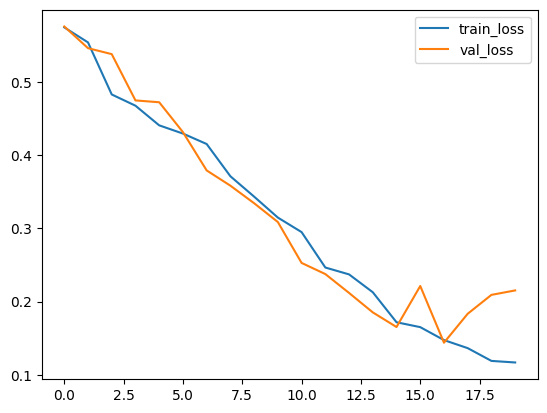

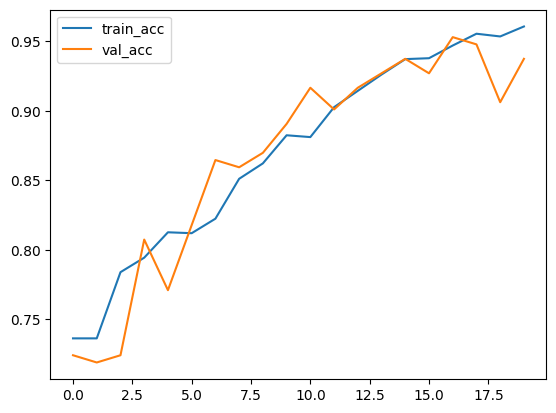

In [152]:

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()

In [153]:
scores = model.evaluate(test_ds)

6/6 [==============================] - 34s 253ms/step - loss: 0.2007 - accuracy: 0.9323


In [154]:
scores

[0.2007460594177246, 0.9322916865348816]

In [155]:
y_pred = model.predict(test_ds)

6/6 [==============================] - 2s 250ms/step


In [156]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

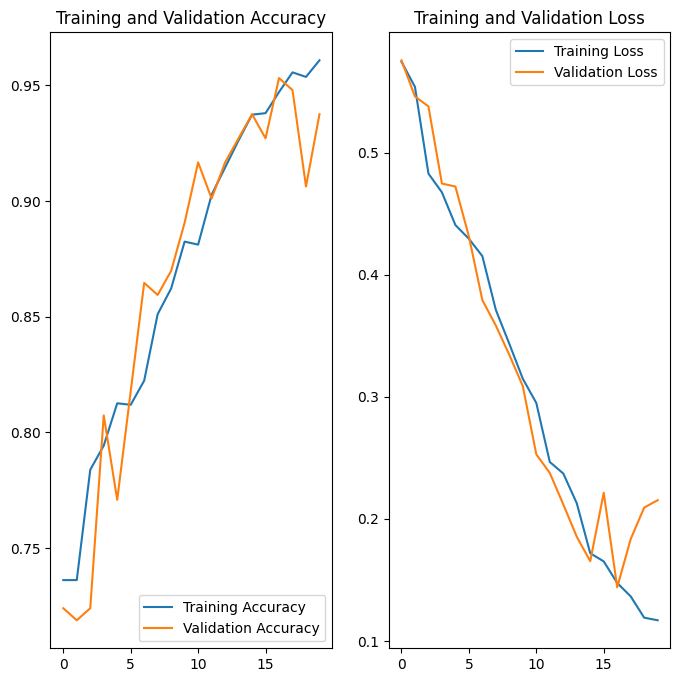

In [157]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Prediction of some data

first image to predict
actual label: FIRE
1/1 [==============================] - 1s 613ms/step
0
predicted label: FIRE


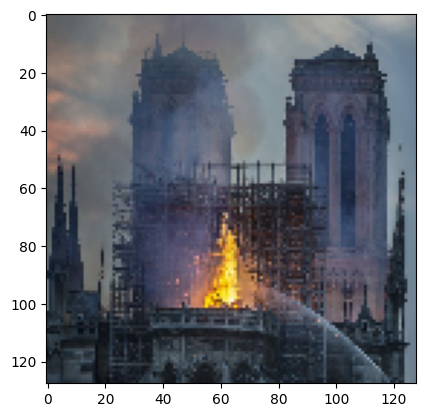

In [158]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(image_batch)
    print(np.argmax(batch_prediction[0]))
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [159]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i])
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 256ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 60ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 53ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 56ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 68ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 56ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 56ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 56ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 54ms/step


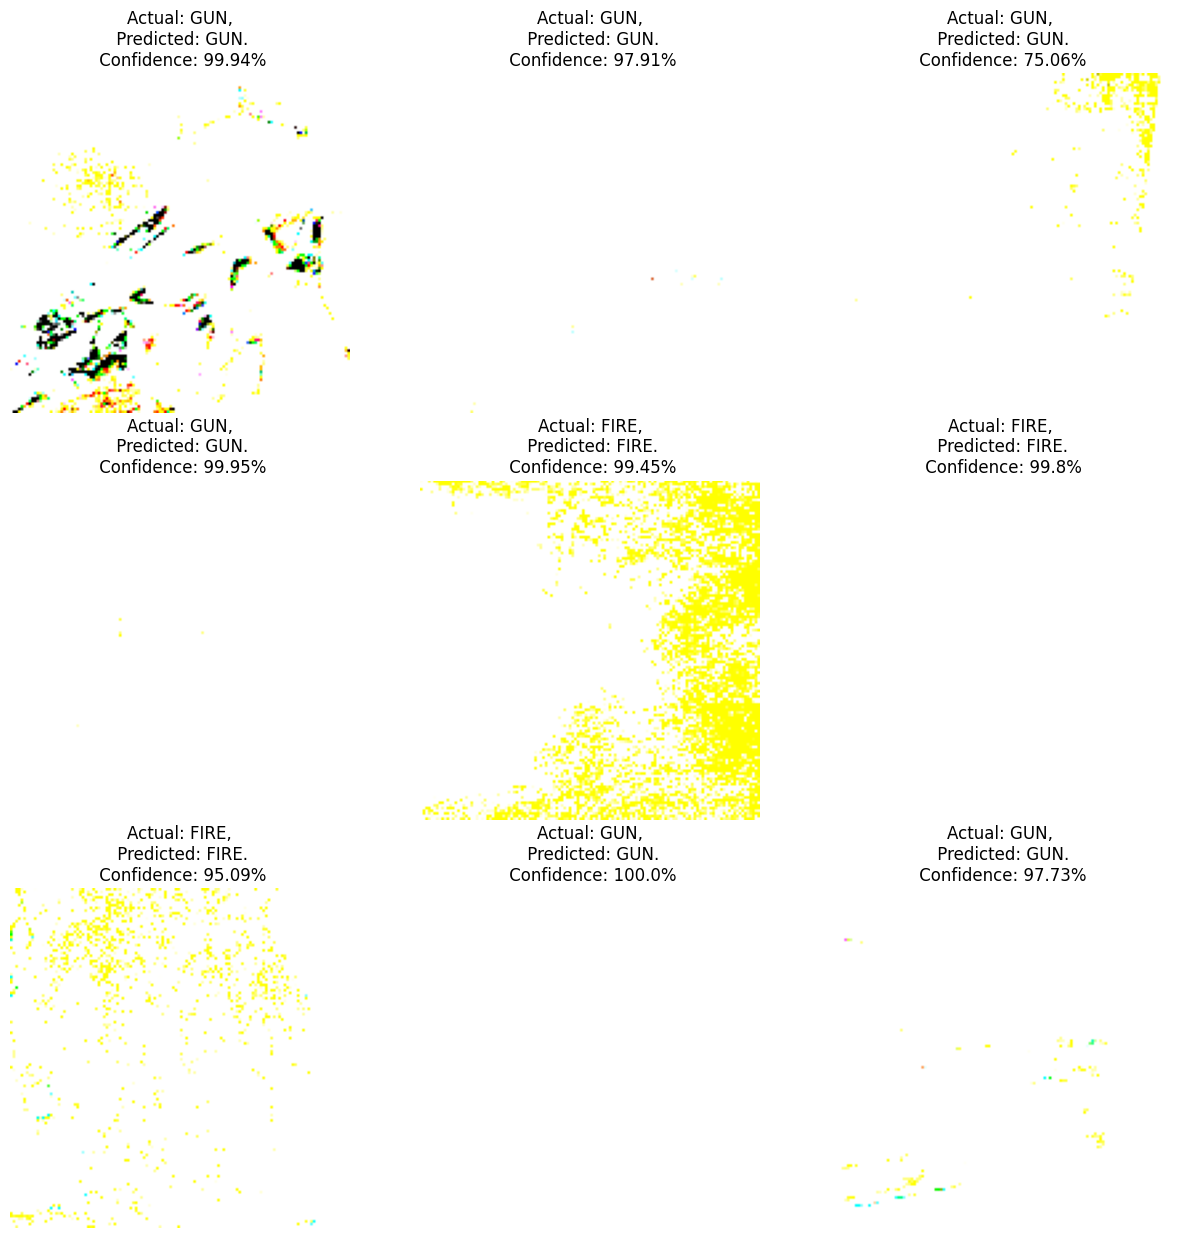

In [160]:
plt.figure(figsize=(15, 15))
for images, labels in val_ds:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        
        predicted_class, confidence = predict(model, images[i])
        actual_class = class_names[int(labels[i])] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")
    break

### Saving the Model

Save model in h5 format so that there is just one file and we can upload that to GCP conveniently

In [161]:
model.save("model.h5")

In [162]:
###################################

In [163]:
####VGG16 restnet